# Data preparation

In [40]:
import os
from pathlib import Path
from typing import Callable
import warnings

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
# from segregation.aspatial import MinMax, Dissim
import rasterio as rio
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import cufflinks as cf

data_dir = Path('../data')
cf.go_offline()


In [41]:
def get_xy(
        geodf: gpd.GeoDataFrame,
        geometry_col: str = None,
) -> gpd.GeoDataFrame:

    if not geometry_col:
        geometry_col = geodf.geometry.name

    if geodf[geometry_col].geom_type[0] == 'Point':
        geodf['x'] = geodf[geometry_col].apply(lambda geom: geom.x)
        geodf['y'] = geodf[geometry_col].apply(lambda geom: geom.y)
    else:
        geodf['x'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[0]))
        geodf['y'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[1]))
    return geodf

def kernel_density_surface(
        data: gpd.GeoDataFrame,
        group: str,
        bandwidth,
        cell_size,
        kernel_function: Callable,
):
    pop = get_xy(data)
    pad = bandwidth * 2

    minx, miny, maxx, maxy = pop.geometry.total_bounds

    minx -= pad
    miny -= pad
    maxx += pad
    maxy += pad

    x = np.arange(minx, maxx, cell_size)
    y = np.arange(miny, maxy, cell_size)

    X, Y = np.meshgrid(x, y)

    xy = np.vstack([Y.ravel(), X.ravel()]).T

    U = cdist(xy, pop[['y', 'x']].values, metric='euclidean')
    W = kernel_function(U, bandwidth=bandwidth)

    density = (W * pop[group].values).sum(axis=1).reshape(X.shape)

    geotiff_meta = {
        'driver': 'GTiff',
        'count': 1,
        'dtype': 'float64',
        'width': len(x),
        'height': len(y),
        'crs': data.crs,
        'transform': rio.transform.from_bounds(
            west=minx,
            east=maxx,
            north=maxy,
            south=miny,
            width=len(x),
            height=len(y),
        )
    }

    return density[::-1, ], geotiff_meta

def point_value(point: Point, raster: rio.DatasetReader):
    x, y = point.x, point.y
    r, c = raster.index(x, y)
    value = raster.read(1)[r, c]

    return value

def quartic_kernel(u, bandwidth):
    return np.where(
            np.abs(u) <= bandwidth,
            3 / (np.pi * bandwidth * bandwidth) * (1 - (u / bandwidth) ** 2) ** 2,
            0
    )

In [42]:
def prepare_pop_data(
        population_data: pd.DataFrame,
        num_cols=None,
) -> pd.DataFrame:

    pop_frame = population_data.fillna(value=0)

    if not num_cols:
        num_cols = [
            'total_men',
            'total_women',
            'orthodox',
            'other_christian',
            'other_religion',
        ]

    pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)

    pop_frame['lutheran'] = pop_frame['total_men total_women'.split()].sum(axis=1) \
                            - pop_frame['other_christian orthodox other_religion'.split()].sum(axis=1)

    pop_frame['total'] = pop_frame['other_christian orthodox other_religion lutheran'.split()].sum(axis=1)

    return pop_frame


def handle_combined_plots(
        pop_data: pd.DataFrame,
        target_column: str = 'plot_number',
):
    target_shape = pop_data.shape
    index_columns = pop_data.index.names
    pop_data.reset_index(inplace=True)
    pop_data[target_column] = [e.split(',')[0].strip() for e in pop_data[target_column]]
    pop_data.set_index(index_columns, inplace=True)

    assert pop_data.shape == target_shape

    return pop_data


def remove_institutions(
        pop_data: pd.DataFrame,
        institutions: pd.DataFrame,
        year,
):
    institutions = institutions.set_index(['district', 'plot_number'])
    institutions = institutions.loc[institutions.year == year]

    for idx in institutions.index:
        pop_data = pop_data.drop(index=idx, errors='ignore')

    return pop_data


def split_plots(
        geodataframe: gpd.GeoDataFrame,
        target_col: str,
        separator: str = ',',
) -> gpd.GeoDataFrame:

    new_geodataframe = gpd.GeoDataFrame(columns=geodataframe.columns)

    for _, row in geodataframe.iterrows():
        plots = str(row[target_col]).split(separator)

        if len(plots) < 2:
            new_geodataframe = new_geodataframe.append(row)
            continue

        for plot in plots:
            new_row = row
            new_row[target_col] = plot
            new_geodataframe = new_geodataframe.append(new_row)

    assert len(new_geodataframe.index) == len(list(pd.core.common.flatten(
        [
            str(w).split(separator)
            for w
            in geodataframe[target_col]
        ]))), 'splitting failed'

    return new_geodataframe.reindex()

In [43]:
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

location_data = gpd.read_file(data_dir / 'raw' / 'plots_1878.gpkg').to_crs(epsg=3067)
location_data = split_plots(location_data, target_col='NUMBER')
location_data['district'] = [district_codes[int(d)] for d in location_data['DISTRICT']]
location_data['plot_number'] = [str(i).strip() for i in location_data['NUMBER']]
location_data = location_data.set_index(['district', 'plot_number'])
city = gpd.read_file(data_dir / 'raw' / 'city_1846.shp').to_crs(epsg=3067)
location_data = location_data.loc[~location_data.geometry.within(city.geometry[0]).index.duplicated()]
location_data = location_data.loc[location_data.geometry.within(city.geometry[0])]

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}

lutheran_density = rio.open(data_dir / 'processed' / 'lutheran_density_1880_150_m.tif')
orthodox_density = rio.open(data_dir / 'processed' / 'orthodox_density_1880_150_m.tif')
total_density = rio.open(data_dir / 'processed' / 'total_density_1880_150_m.tif')
location_data['lutheran_density'] = location_data.geometry.apply(point_value, raster=lutheran_density).round(4)
location_data['orthodox_density'] = location_data.geometry.apply(point_value, raster=orthodox_density).round(4)
location_data['total_density'] = location_data.geometry.apply(point_value, raster=total_density).round(4)
location_data.drop(columns=['DISTRICT', 'NUMBER'], inplace=True)

In [44]:
income = pd.read_csv(data_dir / 'interim' / 'income_tax_record_1880.csv', index_col=0)
income.plot_number = income.plot_number.apply(lambda i: i.split(',')[0] if isinstance(i, str) else i)
income.set_index(['district', 'plot_number'], drop=True, inplace=True)
income['total_income'] = income.loc[:,
                         ['estate_income', 'business_income', 'salary_pension_income']
                         ].sum(axis=1)

In [45]:
income.describe()

,estate_income,business_income,salary_pension_income,total_income
count,3336.000000,3336.000000,3336.000000,3336.000000
mean,0.826739,1.786271,2.419964,5.032974
std,3.067548,16.865182,6.133464,18.756135
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000
75%,0.000000,0.000000,2.000000,3.000000
max,40.000000,554.000000,115.000000,562.000000


<AxesSubplot:>

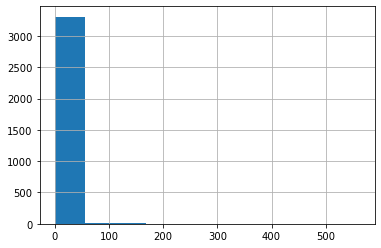

In [46]:
income.total_income.hist()

In [47]:
# income['total_income_log'] = income.total_income.apply(lambda x: np.log(x) if x > 0.01 else 0.0).round(4)
# income.total_income_log.hist()

<AxesSubplot:>

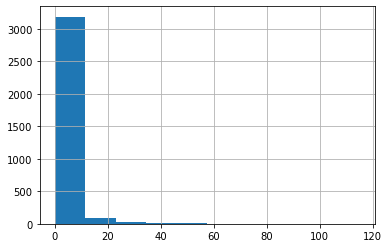

In [48]:
income.salary_pension_income.hist()

In [49]:
income = income.groupby(level=[0, 1]).sum()
income_types = 'estate_income business_income salary_pension_income total_income'.split()
combined_data = location_data.join(income)
combined_data.set_crs(epsg=3067, inplace=True)
bw = 150

for it in income_types:
    combined_data[it] = combined_data[it].fillna(0)

for it in income_types:
    kde, raster_args = kernel_density_surface(
            data=combined_data,
            group=it,
            bandwidth=bw,
            cell_size=25,
            kernel_function=quartic_kernel,
    )
    kde = kde * 10_000

    file = data_dir / 'processed' / f'{it}_1880_{bw}_m.tif'

    with rio.open(file, 'w', **raster_args) as rfile:
        rfile.write(kde, 1)

for it in income_types:
    income_density = rio.open(data_dir / 'processed' / f'{it}_1880_{bw}_m.tif')
    combined_data[it] = location_data.geometry.apply(point_value, raster=income_density).round(4)

In [50]:
population_data = pd.read_csv(
    data_dir / 'interim' / f'pop_by_plot_1880.csv',
    index_col=0,
    dtype={'district': str, 'plot_number': str},
).pipe(prepare_pop_data)

# population_data = population_data.set_index(['district', 'plot_number'], drop=True)
# population_data = population_data.pipe(handle_combined_plots).pipe(remove_institutions, institutions, 1880)
# population_data = population_data.groupby(level=[0, 1]).sum()

# combined_data = combined_data.join(population_data)
# combined_data.reset_index(inplace=True, drop=False)
combined_data.to_file(data_dir / 'processed' / 'spatial_income_1880.gpkg')
combined_data.to_csv(data_dir / 'processed' / 'spatial_income_1880.csv')

In [51]:
combined_data.iloc[::5]

geometry  \
district             plot_number                                   
Valli                1            POINT (594438.860 6732187.013)   
                     6            POINT (594495.434 6732216.091)   
                     11           POINT (594521.316 6732158.374)   
                     16           POINT (594564.637 6732163.476)   
                     21           POINT (594604.938 6732155.022)   
...                                                          ...   
Pietarin_esikaupunki 243          POINT (595625.169 6732263.513)   
                     249          POINT (595575.273 6732203.102)   
                     259          POINT (595458.663 6732353.796)   
                     265          POINT (595563.572 6732338.690)   
                     270          POINT (595679.450 6732299.715)   

                                  lutheran_density  orthodox_density  \
district             plot_number                                       
Valli                1                     53.8190            0.4296   
                     6                     90.7091            1.4659   
                     11                   111.3023            6.7553   
                     16                   121.8282            9.0340   
                     21                   127.2245           15.2944   
...                                            ...               ...   
Pietarin_esikaupunki 243                   32.2183            3.7363   
                     249                    8.9921            1.0515   
                     259                   32.5349            6.0191   
                     265                   22.5529            5.5714   
                     270                   42.8118            4.5314   

                                  total_density  estate_income  \
district             plot_number                                 
Valli                1                  55.4937        40.6120   
                     6                  94.9508        50.5644   
                     11                120.7489        67.6724   
                     16                133.2888        69.7253   
                     21                143.9616        59.4536   
...                                         ...            ...   
Pietarin_esikaupunki 243                35.9546        14.3775   
                     249                10.0435         6.6061   
                     259                38.5540         6.7135   
                     265                28.1243        16.4770   
                     270                47.3433        13.0767   

                                  business_income  salary_pension_income  \
district             plot_number                                           
Valli                1                   115.0492               101.3581   
                     6                   189.3170               145.9907   
                     11                  283.8758               186.9861   
                     16                  411.7326               188.6214   
                     21                  448.9223               177.9839   
...                                           ...                    ...   
Pietarin_esikaupunki 243                   8.9268                23.2145   
                     249                   4.0208                12.5382   
                     259                  10.1634                11.8120   
                     265                  19.1123                28.0793   
                     270                   8.4595                21.6893   

                                  total_income              x             y  
district             plot_number                                             
Valli                1                257.0192  594438.860314  6.732187e+06  
                     6                385.8720  594495.433645  6.732216e+06  
                     11               538.5343  594521.315502  6.732158e+0

In [52]:
combined_data.loc[:, 'lutheran_density orthodox_density total_income'.split()].scatter_matrix()